# try to read AZFP


When converting to netcdf we get a `math domain error`. My understanding is that echopype assumes that ancilary variables like temperature, pitch, roll etc are in the '01A' file, and tries to create datavariables for these in xarray. however for the glider AZFP none of these are recorded. They are available from the glider, but need to be added into the processing stream. Unfortunatly echopype wont convert any of the data without those variabels

In [1]:
from echopype.convert import Convert
from echopype import Process

from collections import defaultdict
from struct import unpack
import numpy as np

from datetime import datetime as dt
from datetime import timezone
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
fname = './data/19011717'
# fname = './data/19010215'

# data_tmp = Convert(fname + '.01A', fname + '.XML')
data_tmp = Convert(fname + '.01A', './data/NLB_test.XML')
# data_tmp.raw2nc()

In [3]:
data_tmp.filename[0]



'./data/19011717.01A'

# code below from `parse_raw`

In [4]:
unpacked_data = defaultdict(list)
fields = data_tmp.get_fields()
with open(data_tmp.filename[0], 'rb') as file:
    ping_num = 0
    eof = False
    while not eof:
        header_chunk = file.read(data_tmp.HEADER_SIZE)
        if header_chunk:
            header_unpacked = unpack(data_tmp.HEADER_FORMAT, header_chunk)

            # Reading will stop if the file contains an unexpected flag
            if data_tmp._split_header(file, header_unpacked, unpacked_data, fields):
                # Appends the actual 'data values' to unpacked_data
                data_tmp._add_counts(file, ping_num, unpacked_data)
                if ping_num == 0:
                    # Display information about the file that was loaded in
                    data_tmp._print_status(data_tmp.filename[0], unpacked_data)
                # Compute temperature from unpacked_data[ii]['ancillary][4]
#                 unpacked_data['temperature'].append(compute_temp(unpacked_data['ancillary'][ping_num][4]))
                # compute x tilt from unpacked_data[ii]['ancillary][0]
#                 unpacked_data['tilt_x'].append(
#                     compute_tilt(unpacked_data['ancillary'][ping_num][0],
#                                     self.parameters['X_a'], self.parameters['X_b'],
#                                     self.parameters['X_c'], self.parameters['X_d']))
#                 # Compute y tilt from unpacked_data[ii]['ancillary][1]
#                 unpacked_data['tilt_y'].append(
#                     compute_tilt(unpacked_data['ancillary'][ping_num][1],
#                                     self.parameters['Y_a'], self.parameters['Y_b'],
#                                     self.parameters['Y_c'], self.parameters['Y_d']))
#                 # Compute cos tilt magnitude from tilt x and y values
#                 unpacked_data['cos_tilt_mag'].append(
#                     math.cos((math.sqrt(unpacked_data['tilt_x'][ping_num] ** 2 +
#                                         unpacked_data['tilt_y'][ping_num] ** 2)) * math.pi / 180))
                # Calculate voltage of main battery pack
#                 unpacked_data['battery_main'].append(
#                     compute_battery(unpacked_data['ancillary'][ping_num][2]))
#                 # If there is a Tx battery pack
#                 unpacked_data['battery_tx'].append(
#                     compute_battery(unpacked_data['ad'][ping_num][0]))
            else:
                break
        else:
            # End of file
            eof = True
        ping_num += 1



19:56:31 converting file 19011717.01A with NLB_test.XML, time of first ping 2019-Jan-17 17:30:06


In [5]:
# ping_num = 500
# unpacked_data['ancillary'][ping_num][4]
# unpacked_data['ancillary'][ping_num][4]

In [6]:
unpacked_data.keys()

dict_keys(['profile_flag', 'profile_number', 'serial_number', 'ping_status', 'burst_int', 'year', 'month', 'day', 'hour', 'minute', 'second', 'hundredths', 'dig_rate', 'lockout_index', 'num_bins', 'range_samples_per_bin', 'ping_per_profile', 'avg_pings', 'num_acq_pings', 'ping_period', 'first_ping', 'last_ping', 'data_type', 'data_error', 'phase', 'overrun', 'num_chan', 'gain', 'spare_chan', 'pulse_length', 'board_num', 'frequency', 'sensor_flag', 'ancillary', 'ad', 'counts'])

In [7]:
# unpacked_data['frequency']

# main issue !!!!
this issue is not that there is no tilt, temp or roll from the azfp, its that the xml file has no values for the parameter coefficents, so the equation in `compute_temp` chokes because it is dividing by zero

so is there a complete xml somewhere? or can we just make those params something better?

can we make them default to something else, but then use the glider data in reality, or is this important to the `Convert` step?

In [8]:
data_tmp.parameters

{'num_freq': 3,
 'serial_number': 59006,
 'burst_interval': 3.0,
 'pings_per_burst': 1,
 'average_burst_pings': 0,
 'ka': 532.6859171,
 'kb': 3000.0,
 'kc': 2.870441838,
 'A': 0.001466,
 'B': 0.000238809,
 'C': 1.00335e-07,
 'X_a': 0.0,
 'X_b': 0.0,
 'X_c': 0.0,
 'X_d': 0.0,
 'Y_a': 0.0,
 'Y_b': 0.0,
 'Y_c': 0.0,
 'Y_d': 0.0,
 'dig_rate': [20000.0, 20000.0, 20000.0],
 'lock_out_index': [0.0, 0.0, 0.0],
 'gain': [1.0, 1.0, 1.0],
 'pulse_length': [1000.0, 1000.0, 1000.0],
 'DS': [0.02290000021458, 0.02270000055432, 0.02199999988079],
 'EL': [152.3999938965, 136.3999938965, 151.6000061035],
 'TVR': [156.1999969482, 168.5, 165.8999938965],
 'VTX': [157.0, 146.6999969482, 133.3000030518],
 'BP': [0.1306499987841, 0.0107100000605, 0.0107100000605],
 'range_samples': [1999, 1999, 1999],
 'range_averaging_samples': [1, 1, 1],
 'sensors_flag': 0.0}

In [9]:
# check uniquness
# need to do to remove repeated frequency stuff


if np.array(unpacked_data['profile_flag']).size != 1:    # Only check uniqueness once. Will error if done twice
    # fields with num_freq data
    field_w_freq = ('dig_rate', 'lockout_index', 'num_bins', 'range_samples_per_bin',
                    'data_type', 'gain', 'pulse_length', 'board_num', 'frequency')
    # fields to reduce size if the same for all pings
    field_include = ('profile_flag', 'serial_number',
                     'burst_int', 'ping_per_profile', 'avg_pings', 'ping_period',
                     'phase', 'num_chan', 'spare_chan')
    for field in field_w_freq:
        uniq = np.unique(unpacked_data[field], axis=0)
        if uniq.shape[0] == 1:
            unpacked_data[field] = uniq.squeeze()
        else:
            raise ValueError(f"Header value {field} is not constant for each ping")
    for field in field_include:
        uniq = np.unique(unpacked_data[field])
        if uniq.shape[0] == 1:
            unpacked_data[field] = uniq.squeeze()
        else:
            raise ValueError(f"Header value {field} is not constant for each ping")

# `_set_beam_dict`

In [10]:
anc = np.array(unpacked_data['ancillary'])   # convert to np array for easy slicing
dig_rate = unpacked_data['dig_rate']         # dim: freq
freq = np.array(unpacked_data['frequency']) * 1000    # Frequency in Hz


# get the times
ping_time = []
for ping_num, year in enumerate(unpacked_data['year']):
    ping_time.append(np.datetime64(dt(year,
                     unpacked_data['month'][ping_num],
                     unpacked_data['day'][ping_num],
                     unpacked_data['hour'][ping_num],
                     unpacked_data['minute'][ping_num],
                     int(unpacked_data['second'][ping_num] +
                        unpacked_data['hundredths'][ping_num] / 100)).replace(tzinfo=timezone.utc)))

ping_time = ( ping_time - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')

# # Build variables in the output xarray Dataset
N = []   # for storing backscatter_r values for each frequency
Sv_offset = np.zeros(freq.shape)

for ich in range(len(freq)):
#     Sv_offset[ich] = self.calc_Sv_offset(freq[ich], self.unpacked_data['pulse_length'][ich])
    N.append(np.array([unpacked_data['counts'][p][ich] for p in range(len(unpacked_data['year']))]))

tdn = unpacked_data['pulse_length'] / 1e6  # Convert microseconds to seconds
range_samples_xml = np.array(data_tmp.parameters['range_samples'])         # from xml file
range_samples_per_bin = unpacked_data['range_samples_per_bin']    # from data header

"""Set the Beam group.
"""

parameters = data_tmp.parameters


# Largest number of counts along the range dimension among the different channels
longest_range_bin = np.max(unpacked_data['num_bins'])
range_bin = np.arange(longest_range_bin)

# Pad power data
if any(unpacked_data['num_bins'] != longest_range_bin):
    N_tmp = np.full((len(N), len(ping_time), longest_range_bin), np.nan)
    for i, n in enumerate(N):
        N_tmp[i, :, :n.shape[1]] = n
    N = N_tmp
    del N_tmp


range_samples_xml = np.array(parameters['range_samples'])         # from xml file
range_samples_per_bin = unpacked_data['range_samples_per_bin']    # from data header

# Calculate sample interval in seconds
if len(dig_rate) == len(range_samples_per_bin):
    sample_int = range_samples_per_bin / dig_rate
else:
    raise ValueError("dig_rate and range_samples not unique across frequencies")

ds = xr.Dataset({'backscatter_r': (['frequency', 'ping_time', 'range_bin'], N),
                 'equivalent_beam_angle': (['frequency'], parameters['BP']),
                 'gain_correction': (['frequency'], parameters['gain']),
                 'sample_interval': (['frequency'], sample_int,
                                     {'units': 's'}),
                 'transmit_duration_nominal': (['frequency'], tdn,
                                               {'long_name': 'Nominal bandwidth of transmitted pulse',
                                                'units': 's',
                                                'valid_min': 0.0}),
                 'temperature_counts': (['ping_time'], anc[:, 4]),
                 'tilt_x_count': (['ping_time'], anc[:, 0]),
                 'tilt_y_count': (['ping_time'], anc[:, 1]),
#                  'tilt_x': (['ping_time'], unpacked_data['tilt_x']),
#                  'tilt_y': (['ping_time'], unpacked_data['tilt_y']),
#                  'cos_tilt_mag': (['ping_time'], unpacked_data['cos_tilt_mag']),
                 'DS': (['frequency'], parameters['DS']),
                 'EL': (['frequency'], parameters['EL']),
                 'TVR': (['frequency'], parameters['TVR']),
                 'VTX': (['frequency'], parameters['VTX']),
#                  'Sv_offset': (['frequency'], Sv_offset),
                 'number_of_samples_digitized_per_pings': (['frequency'], range_samples_xml),
                 'number_of_digitized_samples_averaged_per_pings': (['frequency'],
                                                                    parameters['range_averaging_samples'])},
                coords={'frequency': (['frequency'], freq,
                                      {'units': 'Hz',
                                       'valid_min': 0.0}),
                        'ping_time': (['ping_time'], ping_time,
                                      {'axis': 'T',
                                       'calendar': 'gregorian',
                                       'long_name': 'Timestamp of each ping',
                                       'standard_name': 'time',
                                       'units': 'seconds since 1900-01-01'}),
                        'range_bin': (['range_bin'], range_bin)},
                attrs={'beam_mode': '',
                       'conversion_equation_t': 'type_4',
                       'number_of_frequency': parameters['num_freq'],
                       'number_of_pings_per_burst': parameters['pings_per_burst'],
                       'average_burst_pings_flag': parameters['average_burst_pings'],
                       # Temperature coefficients
                       'temperature_ka': parameters['ka'],
                       'temperature_kb': parameters['kb'],
                       'temperature_kc': parameters['kc'],
                       'temperature_A': parameters['A'],
                       'temperature_B': parameters['B'],
                       'temperature_C': parameters['C'],
                       # Tilt coefficients
                       'tilt_X_a': parameters['X_a'],
                       'tilt_X_b': parameters['X_b'],
                       'tilt_X_c': parameters['X_c'],
                       'tilt_X_d': parameters['X_d'],
                       'tilt_Y_a': parameters['Y_a'],
                       'tilt_Y_b': parameters['Y_b'],
                       'tilt_Y_c': parameters['Y_c'],
                       'tilt_Y_d': parameters['Y_d']})

<ipython-input-10-165edbd9a809>:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ping_time.append(np.datetime64(dt(year,


In [11]:
ds

<xarray.Dataset>
Dimensions:                                         (frequency: 3, ping_time: 598, range_bin: 1999)
Coordinates:
  * frequency                                       (frequency) int64 38000 ....
  * ping_time                                       (ping_time) float64 1.548...
  * range_bin                                       (range_bin) int64 0 ... 1998
Data variables:
    backscatter_r                                   (frequency, ping_time, range_bin) int64 ...
    equivalent_beam_angle                           (frequency) float64 0.130...
    gain_correction                                 (frequency) float64 1.0 ....
    sample_interval                                 (frequency) float64 5e-05...
    transmit_duration_nominal                       (frequency) float64 0.001...
    temperature_counts                              (ping_time) int64 50631 ....
    tilt_x_count                                    (ping_time) int64 4142 .....
    tilt_y_count                                    (ping_time) int64 4137 .....
    DS                                              (frequency) float64 0.022...
    EL                                              (frequency) float64 152.4...
    TVR                                             (frequency) float64 156.2...
    VTX                                             (frequency) float64 157.0...
    number_of_samples_digitized_per_pings           (frequency) int64 1999 .....
    number_of_digitized_samples_averaged_per_pings  (frequency) int64 1 1 1
Attributes:
    beam_mode:                  
    conversion_equation_t:      type_4
    number_of_frequency:        3
    number_of_pings_per_burst:  1
    average_burst_pings_flag:   0
    temperature_ka:             532.6859171
    temperature_kb:             3000.0
    temperature_kc:             2.870441838
    temperature_A:              0.001466
    temperature_B:              0.000238809
    temperature_C:              1.00335e-07
    tilt_X_a:                   0.0
    tilt_X_b:                   0.0
    tilt_X_c:                   0.0
    tilt_X_d:                   0.0
    tilt_Y_a:                   0.0
    tilt_Y_b:                   0.0
    tilt_Y_c:                   0.0
    tilt_Y_d:                   0.0

# are the temp and tilt data in there? 
it sort of seems like they are? temp doesn't look right...


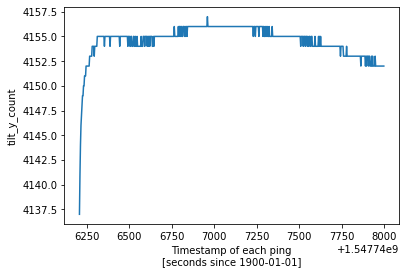

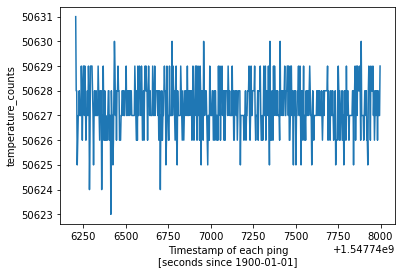

In [12]:
ds.tilt_y_count.plot()

plt.figure()
ds.temperature_counts.plot()

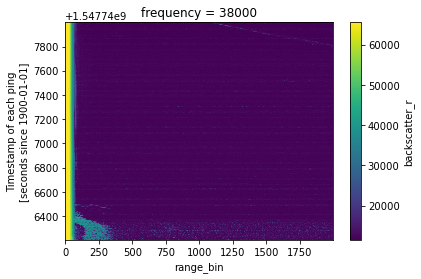

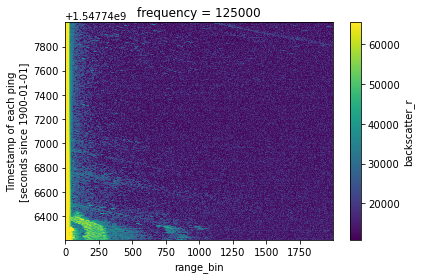

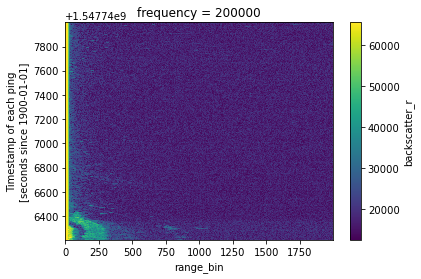

In [13]:

for f in ds.frequency:
    plt.figure()
    ds.backscatter_r.sel(frequency = f).plot()

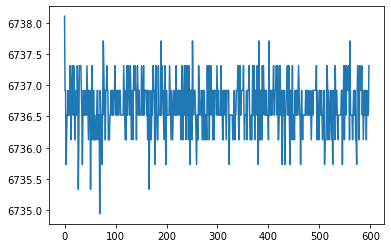

In [14]:
v_in = 2.5 * (ds.temperature_counts.values / 65535)
R = (data_tmp.parameters['ka'] + data_tmp.parameters['kb'] * v_in) / (data_tmp.parameters['kc'] - v_in)

plt.plot(R)

In [15]:
data_tmp.parameters['ka']

532.6859171